In [60]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import numpy as np
import torch
import torch.nn as nn                 # the torch module to implement the Neural Networks
import torch.nn.parallel              # for parallel computations
import torch.optim as optim           # for optimizers
import torch.utils.data               # tools
from torch.autograd import Variable   # for Stochastic Gradient Descent
import random as rnd

df = pd.read_csv('netflix_prize_smaller.csv').astype({
    'MovieId' : 'int16',
    'CustId' : 'int32',
    'Rating' : 'int8',
    'Date' : 'datetime64[us]'
})
probe_df = pd.read_csv('probe_data_new.csv')
print(df)
df['CustId'] = df['CustId'].astype(np.uint32)
df['MovieId'] = df['MovieId'].astype(np.uint16)
df['Rating'] = df['Rating'].astype(np.uint8)

# https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type

print(df.shape)


      CustId  Rating       Date  MovieId
0    1488844       3 2005-09-06        1
1     822109       5 2005-05-13        1
2     885013       4 2005-10-19        1
3      30878       4 2005-12-26        1
4     823519       3 2004-05-03        1
..       ...     ...        ...      ...
755  1954284       5 2005-05-04     1000
756   299636       2 2005-10-27     1000
757  1635449       1 2005-01-10     1000
758   906984       4 2005-05-13     1000
759  2633357       3 2005-10-13     1000

[5010199 rows x 4 columns]
(5010199, 4)


In [61]:
df_movie_summary = df.groupby('MovieId')['Rating'].agg(['count'])
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.80),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print(f'Movie minimum times of review: {movie_benchmark}')

df_cust_summary = df.groupby('CustId')['Rating'].agg(['count'])
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.80),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print(f'Customer minimum times of review: {cust_benchmark}')

df = df[~df['MovieId'].isin(drop_movie_list)]
df = df[~df['CustId'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))


Movie minimum times of review: 3890.0
Customer minimum times of review: 19.0
After Trim Shape: (2687180, 4)


Users:  84525
Movies : 200
        CustId  Rating       Date  MovieId
0       824097       2 2005-07-08        8
3       785314       1 2005-07-13        8
4       243963       3 2005-07-15        8
6      1447783       4 2005-07-19        8
10     1912665       1 2005-08-21        8
...        ...     ...        ...      ...
11848   444860       3 2005-06-01      996
11850  2617594       2 2005-06-27      996
11851  2456457       4 2005-06-28      996
11852  1967445       5 2005-09-05      996
11857    38949       1 2005-10-30      996

[2687180 rows x 4 columns]
RMSE:  1.200662035763676


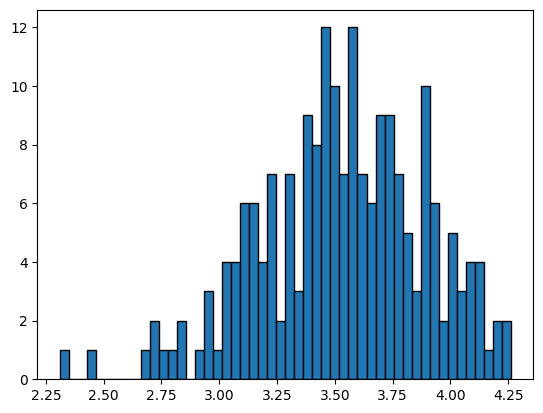

In [62]:
num_movies = df['MovieId'].nunique()
num_users = df['CustId'].nunique()

unique_users = df['CustId'].unique()
unique_movies = df['MovieId'].unique()

averages = {}
for movie in unique_movies:
    averages[movie] = df[df['MovieId'] == movie]['Rating'].mean()

plt.hist(averages.values(), bins=50, edgecolor='black')   

print("Users: ", num_users)
print("Movies :",num_movies)

x = df[['CustId','Rating', 'MovieId']].values
y = df['Rating'].values
print(df)
x_training, x_test, y_training, y_test = train_test_split(x, y, test_size=0.2)
# x_train, x_val, y_train, y_val = train_test_split(x_training, y_training, test_size=0.1)

from scipy import stats

def percentile_to_rating(percentile):
    rating = 0
    if(percentile < .05):
        rating = 1
    elif(percentile < .10):
        rating = 2
    elif(percentile < .43):
        rating = 3
    elif(percentile < .78):
        rating = 4
    else:
        rating = 5
    return rating    

results = []
for row in x_test:
   average = averages[row[2]]
   percentile = stats.percentileofscore(list(averages.values()), average) 
   results.append(percentile_to_rating(percentile/100))

MSE = mean_squared_error(y_test, results)
print("RMSE: ", pow(MSE,1/2))